# Reduce Learning Rate: 

## 隨訓練更更新次數，將Learning rate逐步減小

• 因為通常損失函數越接近谷底的位置，開口越小 – 需要較小的Learning rate 才可以再次下降

## 可行的調降方式

•每更更新n次後，將Learning rate做一次調降 – schedule decay

•當經過幾個epoch後，發現performance沒有進步 – Reduce on plateau


## A. LearningRateScheduler

1.在每個 epoch 開始前，得到目前 lr

2.根據 schedule function 重新計算 lr，比如 epoch = n 時， new_lr = lr * 0.1

3.將 optimizer 的 lr 設定為 new_lr

4.根據 shhedule 函式，假設要自訂的話，它應該吃兩個參數：epoch & lr


## B. ReduceLR

1.在每個 epoch 結束時，得到目前監控目標的數值

2.如果目標比目前儲存的還要差的話，wait+1；若若否則 wait 設為 0，目前監控數值更新的數值

3.如果 wait >= patient，new_lr = lr * factor，將 optimizer 的 lr 設定為new_lr，並且 wait 設回 0

## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras
import itertools
import matplotlib.pyplot as plt
%matplotlib inline


# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
"""
建立神經網路，並加入 BN layer
"""
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [8]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 10              # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

"""Code Here
建立實驗的比較組合
"""
optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

reduce_lr_factor = [0.99, 0.5, 0.1]

redice_lr_patient = [3, 5, 10]

In [10]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, optimizer_set:%s, reduce_factor: %.2f, reduce_patient: %i" % (i, optimizer_set,reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, optimizer_set:[<keras.optimizers.SGD object at 0x000000000E4CAA88>, <keras.optimizers.Adam object at 0x000000000E4CA248>, <keras.optimizers.RMSprop object at 0x000000000E175B48>], reduce_factor: 0.99, reduce_patient: 3
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_10 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_11 (Batc (None, 256)               1024      
___________________

Epoch 2/10
50000/50000 [==============================] - 5s 104us/step - loss: 1.7308 - accuracy: 0.3971 - val_loss: 1.9648 - val_accuracy: 0.3035
Epoch 3/10
50000/50000 [==============================] - 5s 101us/step - loss: 1.6096 - accuracy: 0.4348 - val_loss: 1.8451 - val_accuracy: 0.3526
Epoch 4/10
50000/50000 [==============================] - 5s 101us/step - loss: 1.5389 - accuracy: 0.4609 - val_loss: 1.7272 - val_accuracy: 0.3995
Epoch 5/10
50000/50000 [==============================] - 5s 103us/step - loss: 1.4826 - accuracy: 0.4814 - val_loss: 1.6611 - val_accuracy: 0.4207
Epoch 6/10
50000/50000 [==============================] - 5s 101us/step - loss: 1.4397 - accuracy: 0.4943 - val_loss: 1.5951 - val_accuracy: 0.4444
Epoch 7/10
50000/50000 [==============================] - 5s 101us/step - loss: 1.3996 - accuracy: 0.5111 - val_loss: 1.5543 - val_accuracy: 0.4465
Epoch 8/10
50000/50000 [==============================] - 5s 103us/step - loss: 1.3655 - accuracy: 0.5222 - val_

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 6s 118us/step - loss: 2.2165 - accuracy: 0.2762 - val_loss: 2.1313 - val_accuracy: 0.2040
Epoch 2/10
50000/50000 [==============================] - 5s 105us/step - loss: 1.7464 - accuracy: 0.3915 - val_loss: 1.9727 - val_accuracy: 0.2962
Epoch 3/10
50000/50000 [==============================] - 6s 116us/step - loss: 1.6205 - accuracy: 0.4351 - val_loss: 1.8234 - val_accuracy: 0.3616
Epoch 4/10
50000/50000 [==============================] - 6s 111us/step - loss: 1.5481 - accuracy: 0.4598 - val_loss: 1.7221 - val_accuracy: 0.3964
Epoch 5/10
50000/50000 [==============================] - 6s 118us/step - loss: 1.4913 - accuracy: 0.4782 - val_loss: 1.6353 - val_accuracy: 0.4270
Epoch 6/10
50000/50000 [==============================] - 6s 114us/step - loss: 1.4456 - accuracy: 0.4933 - val_loss: 1.5793 - val_accuracy: 0.4422
Epoch 7/10
50000/50000 [==============================] - 5s 1

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 6s 113us/step - loss: 2.2070 - accuracy: 0.2738 - val_loss: 2.1059 - val_accuracy: 0.2309
Epoch 2/10
50000/50000 [==============================] - 5s 108us/step - loss: 1.7469 - accuracy: 0.3895 - val_loss: 1.9300 - val_accuracy: 0.3161
Epoch 3/10
50000/50000 [==============================] - 5s 107us/step - loss: 1.6220 - accuracy: 0.4292 - val_loss: 1.8143 - val_accuracy: 0.3678
Epoch 4/10
50000/50000 [==============================] - 5s 107us/step - loss: 1.5476 - accuracy: 0.4555 - val_loss: 1.7100 - val_accuracy: 0.4096
Epoch 5/10
50000/50000 [==============================] - 6s 112us/step - loss: 1.4932 - accuracy: 0.4771 - val_loss: 1.6356 - val_accuracy: 0.4334
Epoch 6/10
50000/50000 [==============================] - 5s 109us/step - loss: 1.4484 - accuracy: 0.4944 - val_loss: 1.5770 - val_accuracy: 0.4484
Epoch 7/10
50000/50000 [==============================] - 5s 1

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 6s 129us/step - loss: 1.8403 - accuracy: 0.3517 - val_loss: 4.0274 - val_accuracy: 0.2095
Epoch 2/10
50000/50000 [==============================] - 6s 116us/step - loss: 1.5831 - accuracy: 0.4353 - val_loss: 2.0178 - val_accuracy: 0.3387
Epoch 3/10
50000/50000 [==============================] - 6s 116us/step - loss: 1.4832 - accuracy: 0.4731 - val_loss: 1.7480 - val_accuracy: 0.3913
Epoch 4/10
50000/50000 [==============================] - 6s 117us/step - loss: 1.4162 - accuracy: 0.4934 - val_loss: 1.7000 - val_accuracy: 0.4004
Epoch 5/10
50000/50000 [==============================] - 6s 116us/step - loss: 1.3535 - accuracy: 0.5188 - val_loss: 1.5237 - val_accuracy: 0.4648
Epoch 6/10
50000/50000 [==============================] - 6s 119us/step - loss: 1.3044 - accuracy: 0.5393 - val_loss: 1.8539 - val_accuracy: 0.3575
Epoch 7/10
50000/50000 [==============================] - 6s 1

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 6s 129us/step - loss: 1.7914 - accuracy: 0.3738 - val_loss: 3.1119 - val_accuracy: 0.2113
Epoch 2/10
50000/50000 [==============================] - 6s 117us/step - loss: 1.5402 - accuracy: 0.4526 - val_loss: 1.9070 - val_accuracy: 0.3365
Epoch 3/10
50000/50000 [==============================] - 6s 119us/step - loss: 1.4447 - accuracy: 0.4870 - val_loss: 1.6565 - val_accuracy: 0.4063
Epoch 4/10
50000/50000 [==============================] - 6s 125us/step - loss: 1.3738 - accuracy: 0.5113 - val_loss: 1.6346 - val_accuracy: 0.4198
Epoch 5/10
50000/50000 [==============================] - 6s 119us/step - loss: 1.3122 - accuracy: 0.5341 - val_loss: 1.5513 - val_accuracy: 0.4459
Epoch 6/10
50000/50000 [==============================] - 6s 123us/step - loss: 1.2642 - accuracy: 0.5499 - val_loss: 1.5965 - val_accuracy: 0.4382
Epoch 7/10
50000/50000 [==============================] - 6s 1

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 7s 135us/step - loss: 1.8636 - accuracy: 0.3637 - val_loss: 2.0847 - val_accuracy: 0.2037
Epoch 2/10
50000/50000 [==============================] - 6s 120us/step - loss: 1.5319 - accuracy: 0.4644 - val_loss: 1.8404 - val_accuracy: 0.3372
Epoch 3/10
50000/50000 [==============================] - 6s 117us/step - loss: 1.4381 - accuracy: 0.4995 - val_loss: 1.6954 - val_accuracy: 0.4163
Epoch 4/10
50000/50000 [==============================] - 6s 116us/step - loss: 1.3734 - accuracy: 0.5233 - val_loss: 1.6176 - val_accuracy: 0.4388
Epoch 5/10
50000/50000 [==============================] - 6s 120us/step - loss: 1.3181 - accuracy: 0.5450 - val_loss: 1.5355 - val_accuracy: 0.4593
Epoch 6/10
50000/50000 [==============================] - 6s 118us/step - loss: 1.2779 - accuracy: 0.5591 - val_loss: 1.4860 - val_accuracy: 0.4757
Epoch 7/10
50000/50000 [==============================] - 6s 1

Model: "model_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_70 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_71 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_72 (Batc (None, 128)               512

Epoch 3/10
50000/50000 [==============================] - 6s 116us/step - loss: 1.4201 - accuracy: 0.5009 - val_loss: 1.8872 - val_accuracy: 0.3428
Epoch 4/10
50000/50000 [==============================] - 6s 116us/step - loss: 1.3392 - accuracy: 0.5306 - val_loss: 1.8115 - val_accuracy: 0.3525
Epoch 5/10
50000/50000 [==============================] - 5s 107us/step - loss: 1.2820 - accuracy: 0.5503 - val_loss: 2.3798 - val_accuracy: 0.2614
Epoch 6/10
50000/50000 [==============================] - 6s 110us/step - loss: 1.2369 - accuracy: 0.5650 - val_loss: 1.8404 - val_accuracy: 0.3566
Epoch 7/10
50000/50000 [==============================] - 6s 115us/step - loss: 1.1813 - accuracy: 0.5878 - val_loss: 2.1536 - val_accuracy: 0.3099
Epoch 8/10
50000/50000 [==============================] - 6s 111us/step - loss: 1.1433 - accuracy: 0.5993 - val_loss: 2.0714 - val_accuracy: 0.3288
Epoch 9/10
50000/50000 [==============================] - 6s 110us/step - loss: 1.1042 - accuracy: 0.6166 - val_

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 6s 123us/step - loss: 2.2616 - accuracy: 0.2536 - val_loss: 2.1770 - val_accuracy: 0.2110
Epoch 2/10
50000/50000 [==============================] - 6s 122us/step - loss: 1.9020 - accuracy: 0.3432 - val_loss: 2.0514 - val_accuracy: 0.2811
Epoch 3/10
50000/50000 [==============================] - 5s 110us/step - loss: 1.7636 - accuracy: 0.3861 - val_loss: 1.9259 - val_accuracy: 0.3180
Epoch 4/10
50000/50000 [==============================] - 6s 111us/step - loss: 1.6787 - accuracy: 0.4125 - val_loss: 1.8167 - val_accuracy: 0.3561
Epoch 5/10
50000/50000 [==============================] - 6s 113us/step - loss: 1.6165 - accuracy: 0.4357 - val_loss: 1.7521 - val_accuracy: 0.3787
Epoch 6/10
50000/50000 [==============================] - 5s 110us/step - loss: 1.5641 - accuracy: 0.4537 - val_loss: 1.6788 - val_accuracy: 0.4149
Epoch 7/10
50000/50000 [==============================] - 6s 1

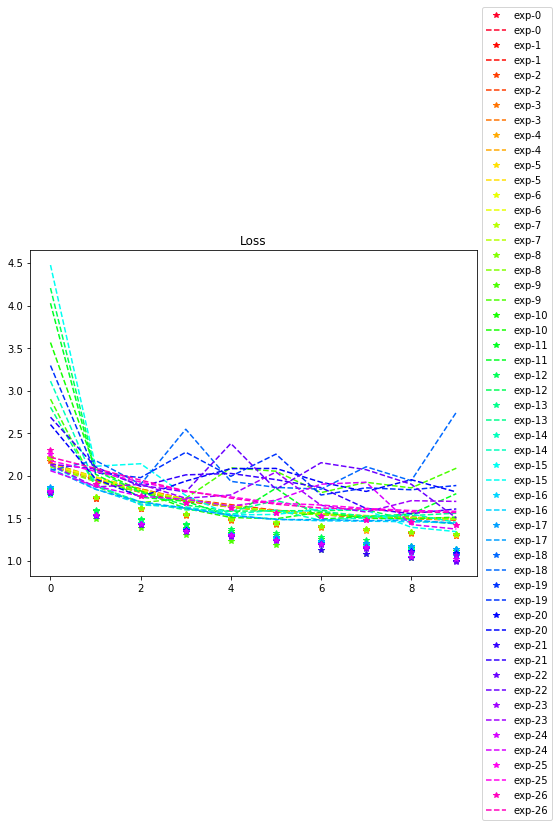

In [15]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '*', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

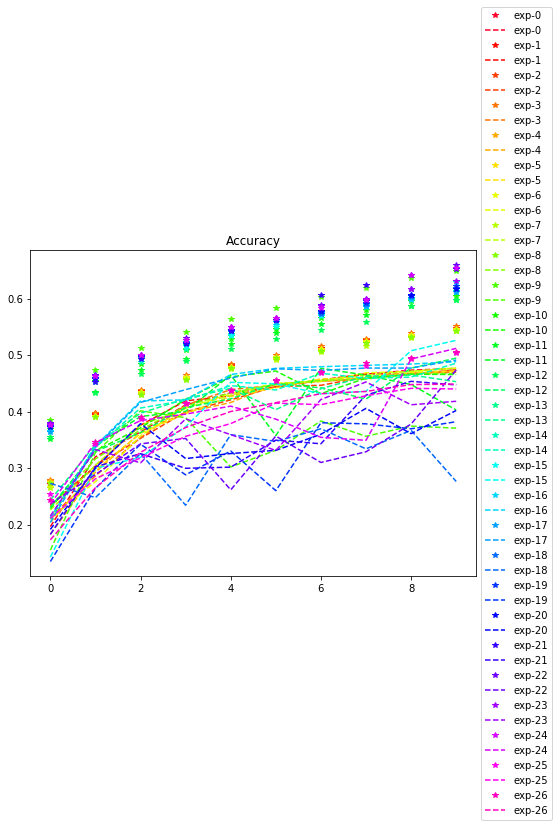

In [14]:
plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '*', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()